In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dask import bag, diagnostics
import pandas as pd
import time

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Project
!pwd

/content/drive/My Drive/Project
/content/drive/My Drive/Project


# Data Exploration
For data exploration, it is done both before and after data preprocessing. 

The data exploration done before data preprocessing is primarily to let us know whether the data that we have crawled is appropriate, and what would be suitable data preprocessing can be done to the raw image data. The following has been conducted:

1.   Plot the class distribution diagram to check if there's imbalance data.
2.   Plot a scatterplot diagram with image width and height as the x and y axis to check if the raw images varies a lot in terms of sizes.

The data exploration done after data preprocessing is to help us understand the important characteristics of the data that would be useful when training and evaluating the model. The following has been conducted:

3.   Take the average of all images per class and display the average images.
4.   Take the difference of the average images among the classes class and show the contrast.
5.   Use Principal Component Analysis (PCA) and plot the eigenimages.





## Data Exploration Done Before Data Preprocessing
### 1. Plot the class distribution diagram to check if there's imbalance data.
If the dataset is imbalanced, the minority class is likely to have poor performance. Hence, if the dataset is imbalanced, crawl more data for the class that has insufficient data. 
From the class distribution diagram, we can see that our final training set is not imbalanced and there is no obvious minority classes.

In [5]:
# Looking into the directory
data_dir = './dataset'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
directories = {class_: os.path.join(os.path.join(data_dir, 'train'), class_) for class_ in classes_train}
number_classes = {class_: len(os.listdir(directories[class_])) for class_ in classes_train}


['validation', 'train']


In [6]:
number_classes

{'angry': 651,
 'disgusted': 930,
 'happy': 609,
 'neutral': 535,
 'sad': 651,
 'scared': 686,
 'surprised': 763}

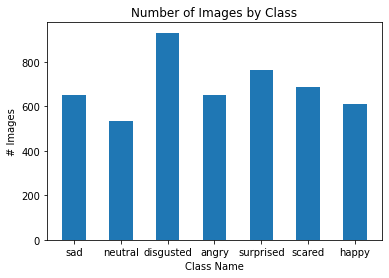

In [7]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

### 2. Plot a scatterplot diagram with image width and height as the x and y axis to check if the raw images varies a lot in terms of sizes.
This would give us clarity on the need for further processing and image standardisation. Following this, we ultimately cropped and resized the raw images as part of data preprocessing.

In [19]:
# Looking into the directory
raw_data_dir = './images'
print(os.listdir(raw_data_dir))
raw_directories = {name: os.path.join(raw_data_dir, name) for name in os.listdir(raw_data_dir)}
raw_directories

['angry man face', 'angry woman face']


{'angry man face': './images/angry man face',
 'angry woman face': './images/angry woman face'}

In [20]:
def get_dims(file):
  '''Returns dimenstions for an RBG image'''
  im = Image.open(file)
  arr = np.array(im)
  if len(arr.shape) == 2:
    h,w = arr.shape
  elif len(arr.shape) == 3:
    h,w,d = arr.shape
  
  return h,w

[########################################] | 100% Completed |  2min 20.2s
[########################################] | 100% Completed |  2min  8.7s


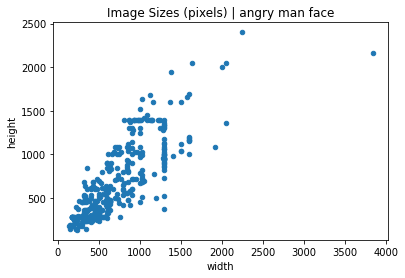

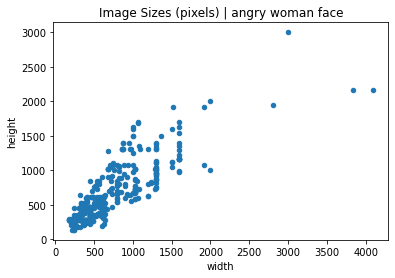

In [22]:
for n,d in raw_directories.items():
  filepath = d
  filelist = [os.path.join(filepath, f) for f in os.listdir(filepath)]
  if '.DS_Store' in filelist:
    filelist.remove('.DS_Store')
  dims = bag.from_sequence(filelist).map(get_dims)
  with diagnostics.ProgressBar():
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Sizes (pixels) | {}'.format(n))

## Preview Images After Data Preprocessing

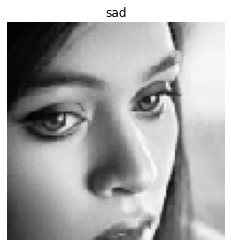

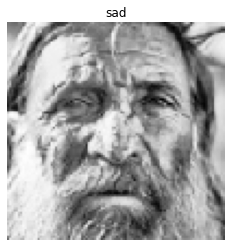

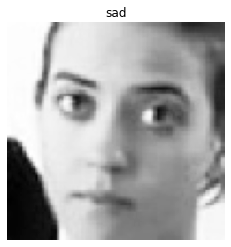

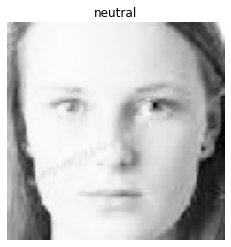

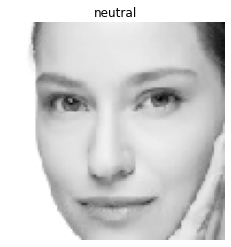

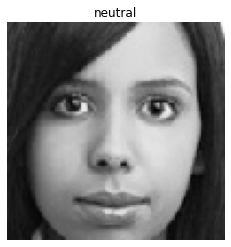

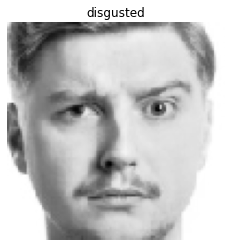

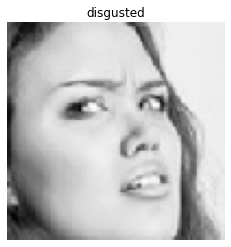

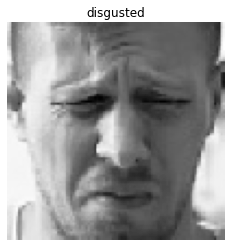

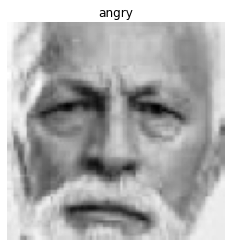

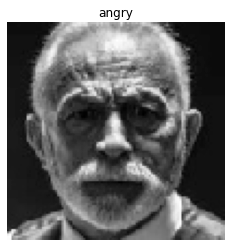

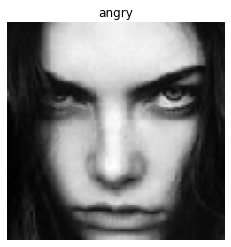

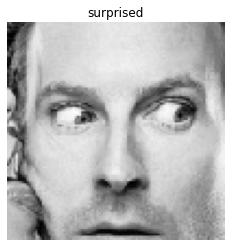

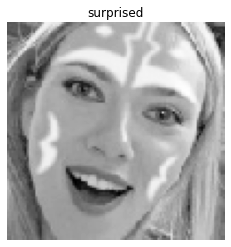

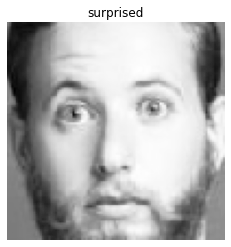

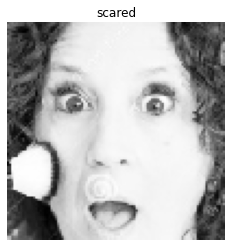

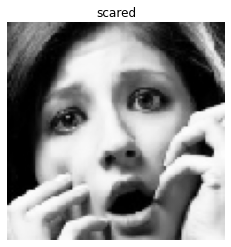

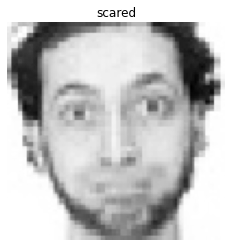

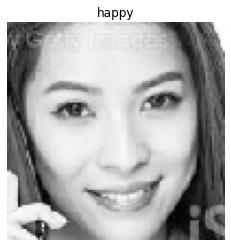

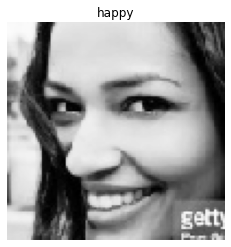

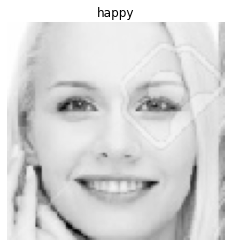

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline

# randomly select 3 of each
imgs = {class_: os.listdir(directories[class_]) for class_ in classes_train}
select = {class_: np.random.choice(imgs[class_], 3, replace=False) for class_ in classes_train}

# plotting 2 x 3 image matrix
# fig = plt.figure(figsize = (len(classes_train)*2, 3*2))
for j in range(len(classes_train)):
  label = classes_train[j]
  for i in range(3):
    fp = os.path.join(directories[label], select[label][i])
    # ax = fig.add_subplot(3, 3, i+j+1)
      
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
    plt.show()

### 3. Take the average of all images per class and display the average images.
After data preprocessing has been done, we are now ready to understand the characterstics of the image data that we would be feeding into the model. 
Over here, we take the average of all images per class to identify if there are distinct differentiating features among the classes. If we can see very distinct difference from the average images, it is likely that the dataset would be suitable for conducting the image classification, and we may be able to expect a decent performance.

Over here, we can observe that for certain classes such as "disgusted", "angry", "surprised" and "happy", there are indeed obvious differences. However, for classes such as "sad", "neutral" and "scared", there are no distinct differences which means that we might be expecting that the model may not be able to have good performance on such classes.

In [12]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    if '.DS_Store' in list_of_filename:
      list_of_filename.remove('.DS_Store')
    for fn in list_of_filename:
        fp = os.path.join(path, fn)
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat
img2np_images = {class_: img2np(directories[class_], imgs[class_]) for class_ in classes_train}

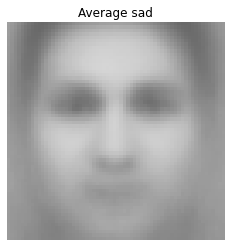

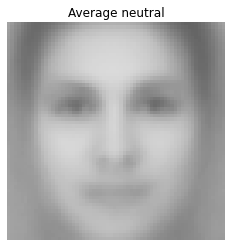

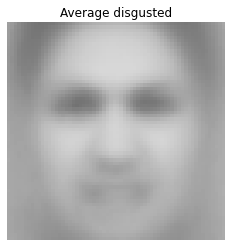

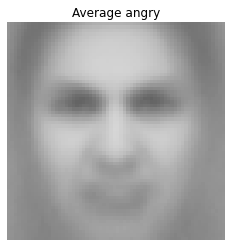

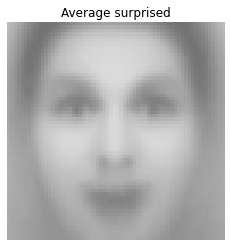

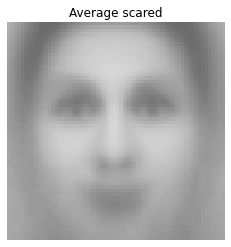

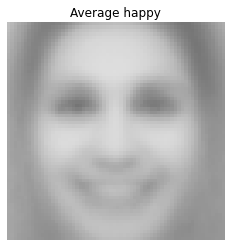

In [13]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

mean = {class_: find_mean_img(img2np_images[class_], class_) for class_ in classes_train}

### 4. Take the difference of the average images among the classes class and show the contrast.
The intention of this is similar to that of #3 just that in #3 we are visualising the difference via human means. Over here, we utilise the average images that have been generated, and conduct a comparison among the different classes by taking the difference between the average images and plotting it. This way we would be able to see the contrast in a more scientific manner.
The observation is similar to what has been described in #4.

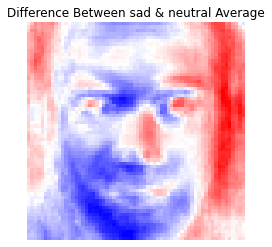

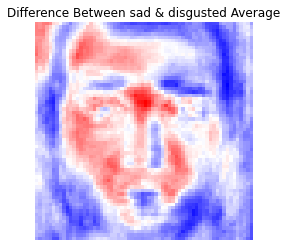

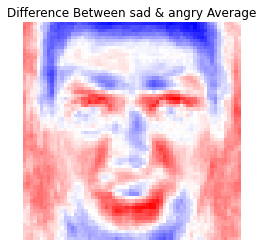

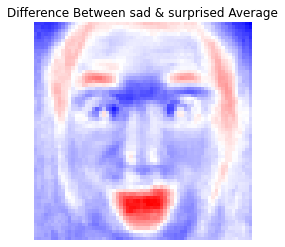

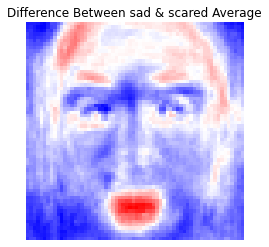

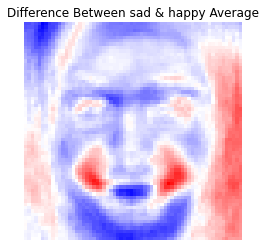

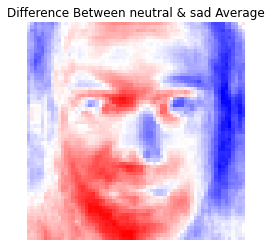

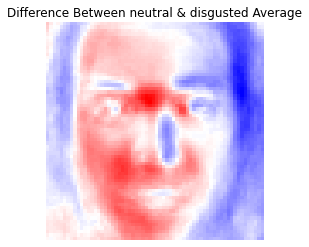

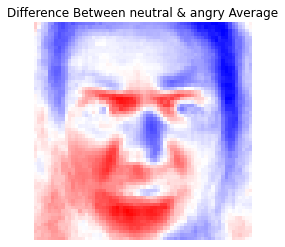

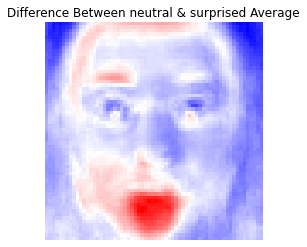

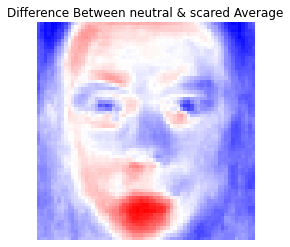

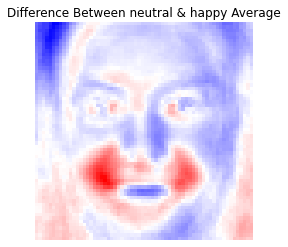

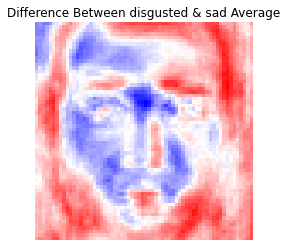

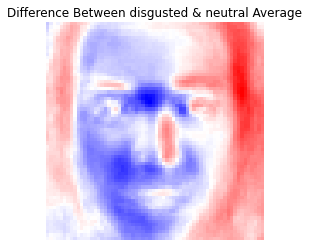

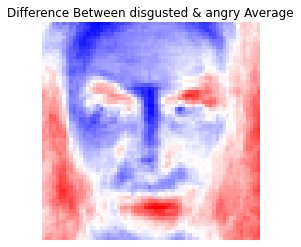

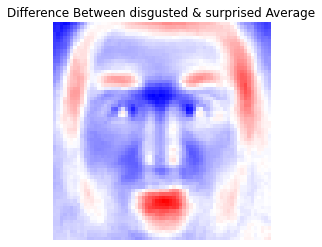

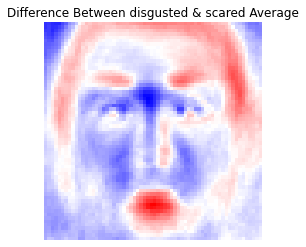

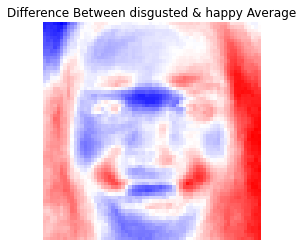

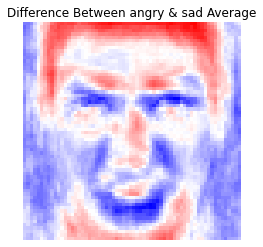

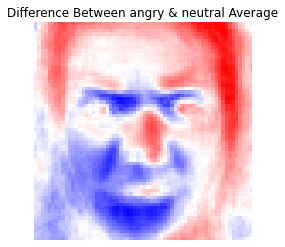

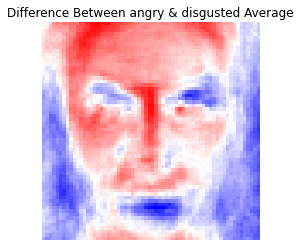

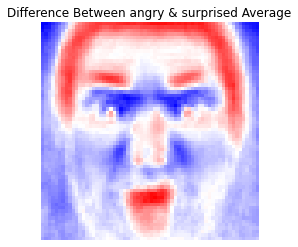

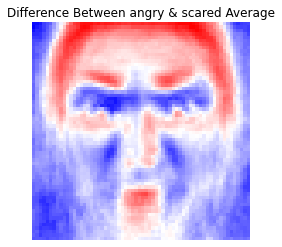

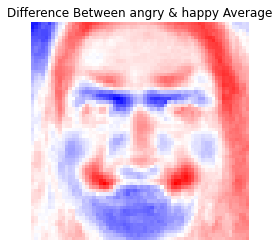

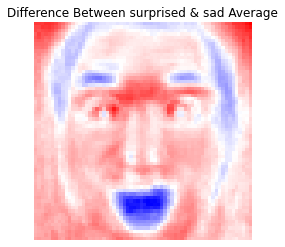

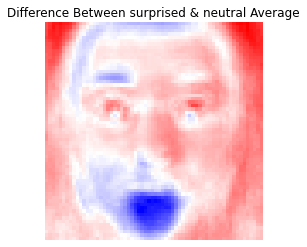

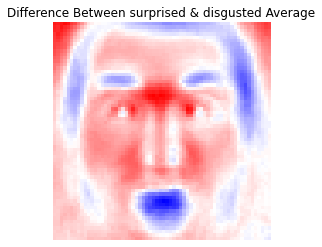

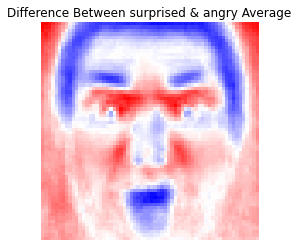

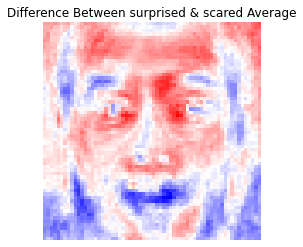

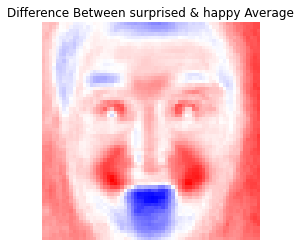

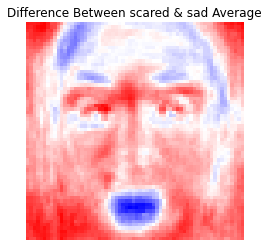

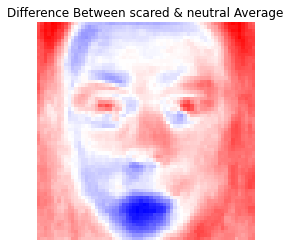

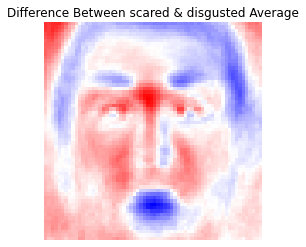

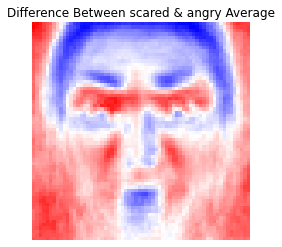

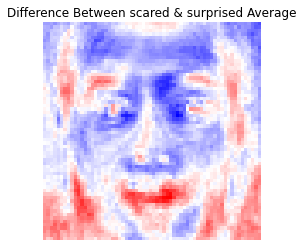

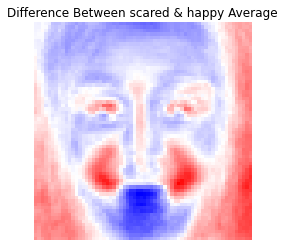

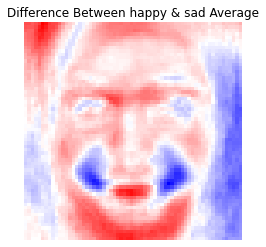

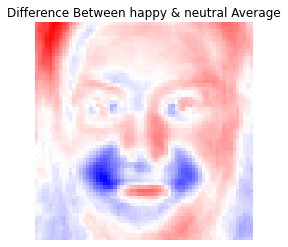

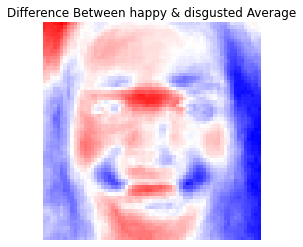

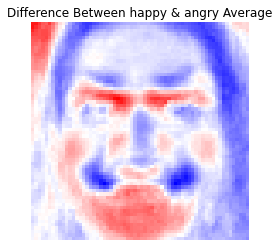

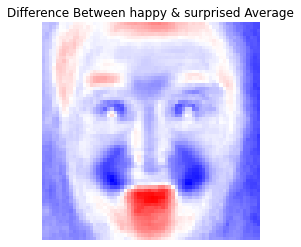

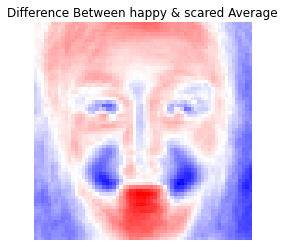

In [14]:
for class_ in classes_train:
  for k, v in mean.items():
    if class_ != k:
      contrast_mean = mean[class_] - v
      plt.imshow(contrast_mean, cmap='bwr')
      plt.title(f'Difference Between {class_} & {k} Average')
      plt.axis('off')
      plt.show()

### 5. Use Principal Component Analysis (PCA) and plot the eigenimages.
This is useful to visualise if there are any components that describe each class the best.

Number of PC:  11


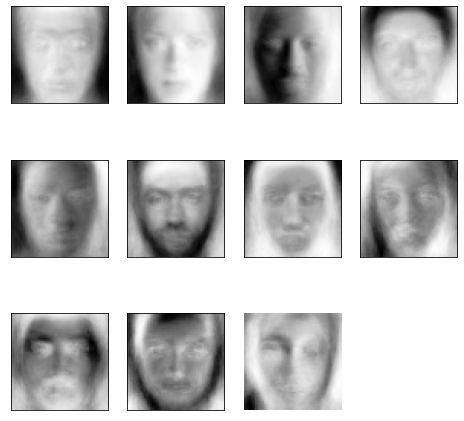

Number of PC:  8


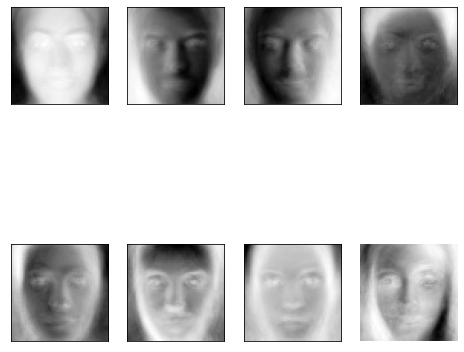

Number of PC:  11


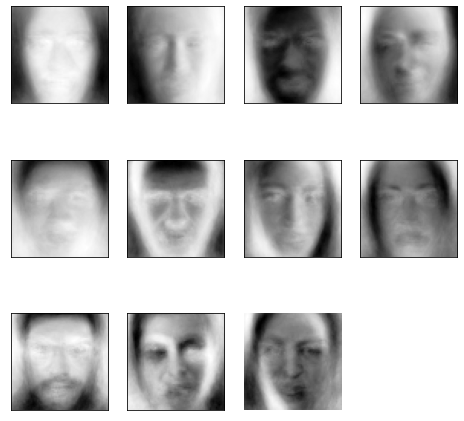

Number of PC:  12


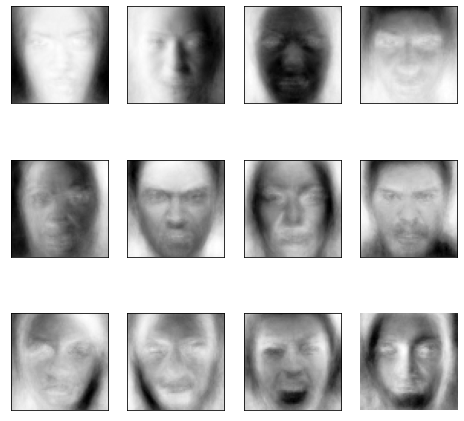

Number of PC:  16


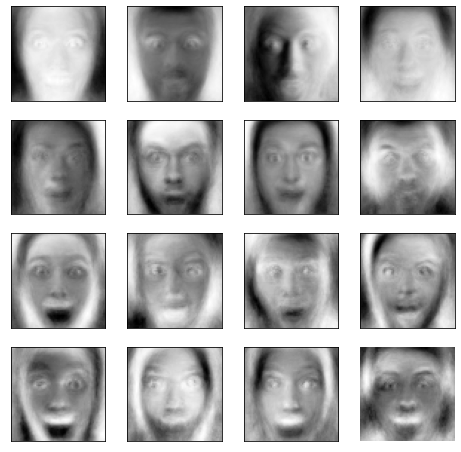

Number of PC:  15


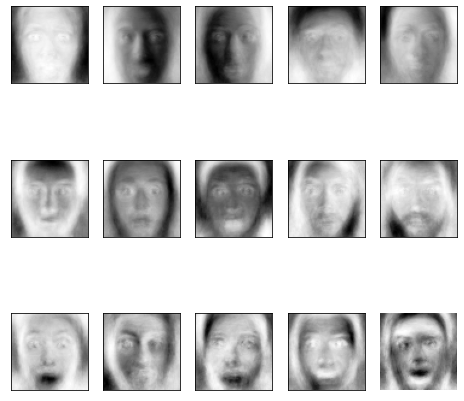

Number of PC:  14


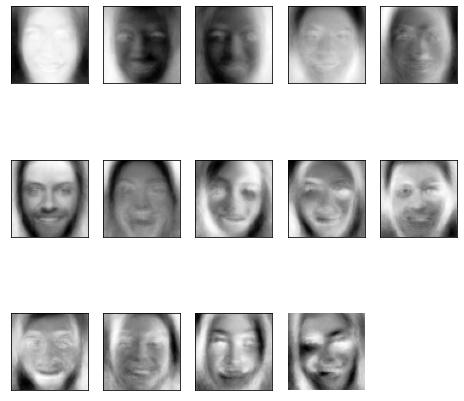

In [82]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
eigen = {k: plot_pca(eigenimages(v, k)) for k, v in img2np_images.items()}